In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-13 06:27:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   107MB/s    in 0.8s    

2020-08-13 06:27:40 (107 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

trained_model = InceptionV3(input_shape = (150,150,3), include_top=False, weights=None)

trained_model.load_weights(weights_file)

for layer in trained_model.layers:
    layer.trainable = False

# See the model summary to select the last layer
# in this model layer named mixed7 was selected
last_layer = trained_model.get_layer('mixed7')
print('Shape of last layer : ',last_layer.output_shape)
last_output = last_layer.output

Shape of last layer :  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import Adam

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(trained_model.input, x)

model.compile(optimizer = Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-08-13 06:40:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  95.8MB/s    in 0.7s    

2020-08-13 06:40:42 (95.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

local_zipfile = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zipfile, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [9]:
cats_train_size = os.listdir(train_cats_dir)
dogs_train_size = os.listdir(train_dogs_dir)
print('Cats Training Size : {}'.format(len(cats_train_size)))
print('Dogs Training Size : {}'.format(len(dogs_train_size)))

Cats Training Size : 1000
Dogs Training Size : 1000


In [10]:
train_data_gen = ImageDataGenerator(rescale=1.0/255,
                                    rotation_range = 45,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

test_data_gen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     batch_size = 16,
                                                     class_mode = 'binary',
                                                     target_size = (150,150))

val_generator = test_data_gen.flow_from_directory(val_dir,
                                                  batch_size = 16,
                                                  class_mode = 'binary',
                                                  target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
history = model.fit(train_generator, 
                    validation_data = val_generator, 
                    epochs = 5,
                    steps_per_epoch=25,
                    verbose=2)

Epoch 1/5
25/25 - 56s - loss: 0.3870 - accuracy: 0.8850 - val_loss: 0.5158 - val_accuracy: 0.8940
Epoch 2/5
25/25 - 56s - loss: 0.4289 - accuracy: 0.8775 - val_loss: 0.1479 - val_accuracy: 0.9490
Epoch 3/5
25/25 - 55s - loss: 0.2553 - accuracy: 0.9200 - val_loss: 0.1238 - val_accuracy: 0.9580
Epoch 4/5
25/25 - 55s - loss: 0.2600 - accuracy: 0.9175 - val_loss: 0.1950 - val_accuracy: 0.9330
Epoch 5/5
25/25 - 56s - loss: 0.2142 - accuracy: 0.9300 - val_loss: 0.1093 - val_accuracy: 0.9580


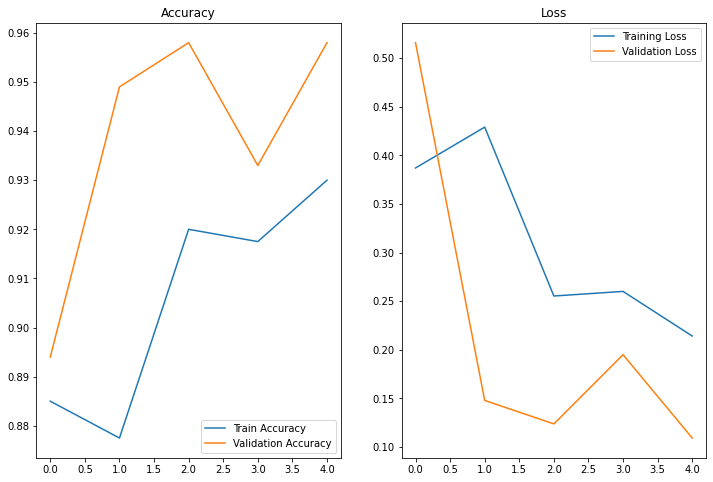

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(5)

plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs,val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()